In [1]:
import pandas as pd
import spacy, copy
from queue import *
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

nodes = pd.read_csv('data/Networks/MilkO/nodes.csv')
edges = pd.read_csv('data/Networks/MilkO/edges.csv')

In [2]:
nlp = spacy.load('pt')

In [8]:
mystr = nlp(u"Gostaria de saber quais são as alternativas de aproveitamento de bezerros machos oriundos de raças leiteiras?")

print([token.lemma_ for token in mystr])

['Gostaria', 'de', 'saber', 'qual', 'ser', 'o', 'alternativo', 'de', 'aproveitamento', 'de', 'bezerro', 'macho', 'oriundo', 'de', 'raça', 'leiteiro', '?']


In [2]:
import pixiedust

Pixiedust database opened successfully


In [3]:
dictionary = set()
for index, node in nodes.iterrows():
    dictionary.add(node['Label'])

In [4]:
graph = {}
for index, edge in edges.iterrows():
    graph[edge['main']]={'weight':0, 'documents':[], 'edges':[]}
    for i in range(1, len(edges.columns)):
        if(isinstance(edge[i], float)):
            break;
        else:
            graph[edge['main']]['edges'].append({'term':edge[i],'weight':0})

            

In [5]:
def processSent(textEntry, graph):
    tokenized = [lemmatizer(token.orth_, token.pos_)[0] for token in nlp(textEntry) if not (token.is_stop or token.is_punct or not token.is_alpha)]
    traversedList = set()
    i = 1
    for word in tokenized:
        if word in dictionary:
            graph[word]['weight']=1
            graph, traversedList = spread(word, graph, traversedList, previousScore=1)
            i=i+1
    return graph

def spread(word, graph, traversedList, previousScore=1, weight=1, decay=0.5,treshold=0.1):
    if graph[word]['weight']==0:
        graph[word]['weight']=previousScore
    futureTraversals = Queue()
    if (previousScore > treshold):
        for i in range(1, len(graph[word]['edges'])-1):
            if graph[word]['edges'][i].get('weight')==0:
                graph[word]['edges'][i].update({'weight':previousScore})
            graph[word]['edges'][i].update({'weight':graph[word]['edges'][i].get('weight')*decay})
            if graph[word]['edges'][i]['term'] not in traversedList:
                futureTraversals.put({'term':graph[word]['edges'][i].get('term'), 'weight':graph[word]['edges'][i].get('weight')})
                traversedList.add(graph[word]['edges'][i].get('term'))
        if(not futureTraversals.empty()):
            while not futureTraversals.empty():
                totraverse = futureTraversals.get()
                graph, traversedList = spread(word=totraverse['term'], graph=graph, traversedList=traversedList, previousScore=totraverse['weight'])

    else:
        return graph, traversedList
    return graph, traversedList

def activeGraph(graph):
    gcopy = copy.deepcopy(graph)
    itemsToPop = []
    for val in gcopy:
        if gcopy[val]['weight']==0:
            itemsToPop.append(val)
        else:
            for edge in gcopy[val]['edges']:
                if edge['weight'] ==0:
                    gcopy[val]['edges'].remove(edge)
    for item in itemsToPop:
        gcopy.pop(item, None)
    return gcopy


        


In [11]:
#%%pixie_debugger
g2 = copy.deepcopy(graph)
g2 = processSent("""
Olá, gostaria de saber a diferença entre: vacas secas, vacas solteiras e vacas amojando.

Agradeço desde já!

""", g2)
print(activeGraph(g2))


{'concentração': {'weight': 0.0625, 'documents': [], 'edges': [{'term': 'magnésio', 'weight': 0}, {'term': 'silagem', 'weight': 0}, {'term': 'alto', 'weight': 0}, {'term': 'proteína', 'weight': 0}, {'term': 'alimento', 'weight': 0}, {'term': 'mineral', 'weight': 0}]}, 'alta': {'weight': 0.125, 'documents': [], 'edges': [{'term': 'concentração', 'weight': 0.0625}, {'term': 'raça', 'weight': 0.0625}, {'term': 'grande', 'weight': 0.0625}]}, 'perda': {'weight': 0.0625, 'documents': [], 'edges': [{'term': 'gordura', 'weight': 0}, {'term': 'proteína', 'weight': 0}]}, 'parto': {'weight': 0.5, 'documents': [], 'edges': [{'term': 'dieta', 'weight': 0.25}]}, 'tratamento': {'weight': 0.25, 'documents': [], 'edges': [{'term': 'resíduo', 'weight': 0.125}, {'term': 'antibiótico', 'weight': 0.125}, {'term': 'sistema', 'weight': 0.125}, {'term': 'parto', 'weight': 0.125}, {'term': 'infecção', 'weight': 0.125}, {'term': 'sintoma', 'weight': 0.125}, {'term': 'quarto', 'weight': 0.125}]}, 'ordenha': {'we

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


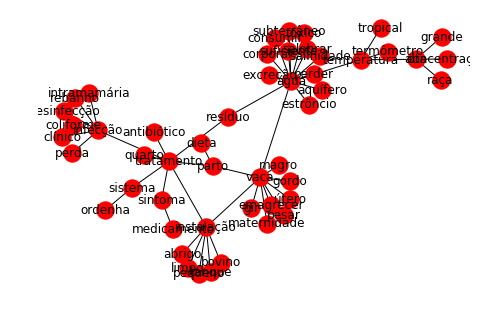

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
#%matplotlib inline
def toNetworkx(graph):
    G = nx.Graph()
    for node in graph:
        for edge in graph[node]['edges']:
            if edge['weight']!=0:
                G.add_edge(node, edge['term'])
    return G
G = toNetworkx(activeGraph(g2))
nx.draw(G, with_labels=True)
plt.draw()
plt.show()